In [1]:
import brainio

raw_assembly = brainio.get_assembly('dicarlo.muri1320.2023.v1.pico.psth.raw')
print(raw_assembly)

Loading catalog from entrypoints
Loading lookup from /braintree/home/msch/miniconda3/envs/pipeline_analysis/lib/python3.11/site-packages/brainio_dicarlo/lookup.csv
<xarray.NeuronRecordingAssembly 'data' (presentation: 40127, neuroid: 192,
                                        time_bin: 10)>
array([[[0, 0, 0, ..., 0, 2, 1],
        [0, 0, 0, ..., 1, 2, 0],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 4, 3, ..., 1, 1, 1]],

       [[4, 1, 3, ..., 1, 0, 0],
        [2, 0, 3, ..., 0, 0, 0],
        [2, 0, 2, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[0, 5, 0, ..., 0, 2, 0],
        [0, 0, 0,

In [2]:
from pipeline_analysis import print_assembly_info

print_assembly_info(raw_assembly)

unique images: 1318
repetitions: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17]), array([11532,  7921,  5284,  5272,  3956,  2168,  1324,  1324,  1319,
          10,     3,     2,     2,     2,     2,     2,     2,     2]))

electrodes: 192
regions: ['IT']
subregions: ['aIT', 'pIT']

time bins: [(70, 80), (80, 90), (90, 100), (100, 110), (110, 120), (120, 130), (130, 140), (140, 150), (150, 160), (160, 170)]


## filter neuroids

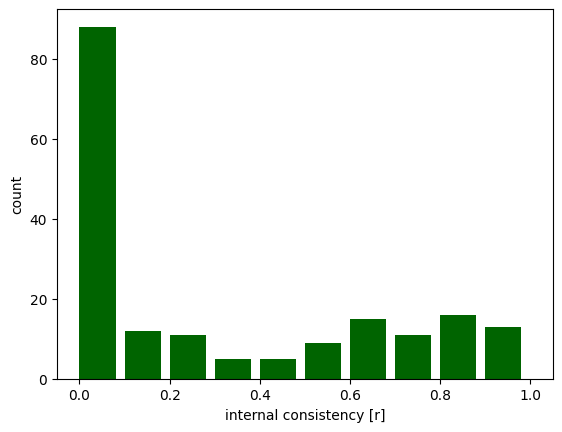

In [3]:
from pipeline_analysis.internal_consistency import plot_consistencies

plot_consistencies(raw_assembly)

plot cumulative

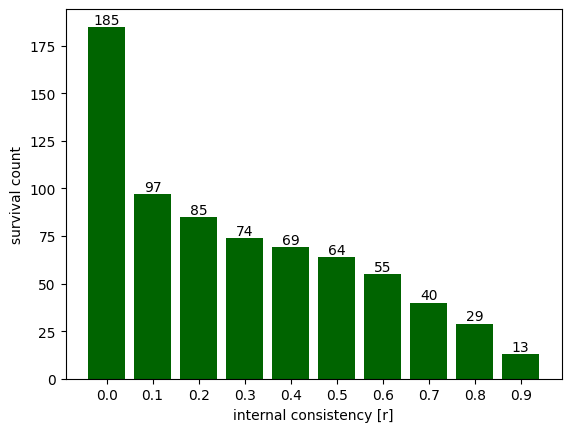

In [4]:
from pipeline_analysis.internal_consistency import plot_consistencies_survival_count

plot_consistencies_survival_count(raw_assembly)

In [5]:
from pipeline_analysis.internal_consistency import filter_assembly

filtered_assembly = filter_assembly(raw_assembly, consistency_threshold=0.7)
print(f"{len(filtered_assembly['neuroid'])} good neuroids > 0.7: {filtered_assembly['neuroid_id'].values}")

40 good neuroids > 0.7: ['A-007' 'A-008' 'A-023' 'B-016' 'B-017' 'B-019' 'B-020' 'B-021' 'B-022'
 'B-023' 'C-001' 'C-002' 'C-003' 'C-004' 'C-008' 'C-012' 'C-013' 'C-014'
 'C-015' 'C-016' 'C-024' 'D-001' 'D-003' 'D-004' 'D-005' 'D-006' 'D-007'
 'D-008' 'D-009' 'D-010' 'D-013' 'D-030' 'D-031' 'E-005' 'E-006' 'E-007'
 'E-008' 'E-009' 'F-007' 'F-008']


plot consistencies over time

time_bin: 100%|██████████| 10/10 [02:59<00:00, 17.93s/it]


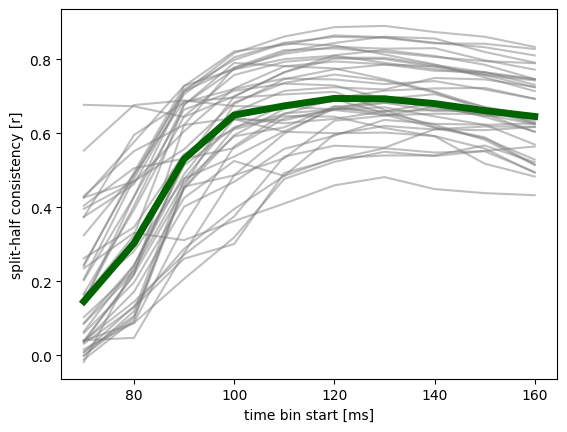

In [6]:
from pipeline_analysis.internal_consistency import plot_internal_consistency_over_time

plot_internal_consistency_over_time(filtered_assembly)

## average out repetitions and time

In [7]:
from pipeline_analysis import average_time_and_repetitions

assembly = average_time_and_repetitions(filtered_assembly)
print(assembly)

<xarray.NeuronRecordingAssembly 'data' (presentation: 1320, neuroid: 40)>
array([[0.93333333, 0.85666667, 0.89      , ..., 0.81666667, 0.75666667,
        0.70666667],
       [1.35862069, 0.53103448, 0.86896552, ..., 0.52068966, 0.65172414,
        0.52758621],
       [1.584375  , 0.6       , 0.584375  , ..., 0.628125  , 0.6125    ,
        0.53125   ],
       ...,
       [0.98387097, 0.60645161, 0.52258065, ..., 0.6516129 , 0.3483871 ,
        0.42903226],
       [1.41612903, 0.66451613, 0.43225806, ..., 0.54516129, 0.57741935,
        0.47096774],
       [0.85483871, 0.73870968, 0.80967742, ..., 0.74193548, 0.39354839,
        0.5483871 ]])
Coordinates:
  * neuroid                        (neuroid) MultiIndex
  - filter_high                    (neuroid) int64 6000 6000 6000 ... 6000 6000
  - adapter_version                (neuroid) object 'adaptorAIT.v1.2023' ... ...
  - array                          (neuroid) object '6250-002929' ... '6250-0...
  - monkey_directory               (ne

## Readout capability

num sites: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


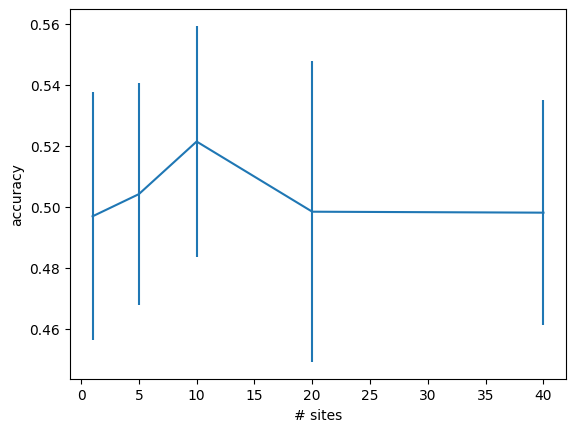

In [8]:
from pipeline_analysis.readout_performance import plot_sites_vs_accuracy

plot_sites_vs_accuracy(assembly)